In [1]:
import os
import sys

if os.path.abspath('../..') not in sys.path:
    sys.path.append(os.path.abspath('../..'))
    
import json
import shutil
import datetime

from dateutil.relativedelta import relativedelta
import tqdm

import scipy
import scipy.stats as st
from scipy.spatial import distance

import numpy as np
import pandas as pd

from sqlalchemy.orm.exc import NoResultFound

from src.corpus import load_tweets
from src.dataset import load_dataset 
from src.config import config
from src.utils.backup import FileBackup
from src.dashboard.models import db, Collection, CollectionTopicProba, Document, TopicModelLoader, Topic, Subject
from src.dashboard.app import app

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
POSITIONS_MAP = {
    'Meteorologist': 'Meteorologist',
    'Reporter': 'Reporter',
    'Producer': 'Reporter',
    'Journalist': 'Reporter',
    'Editor': 'Reporter',
    'Other': 'Other',
    'Student': 'Other',
    'Academic': 'Other',
    'Met Producer': 'Meteorologist',
    'News Director': 'Reporter',
    'Vice President': 'Reporter', 
    'Photographer': 'Reporter'
}

In [3]:
with app.app_context():
    model_loader = None
    for model_loader in TopicModelLoader.query.all():
        if (model_loader.model.num_epochs, model_loader.model.num_topics) == (1, 6):
            break
    cs = Collection.query.all()
    data, tuples = [], []
    for c in tqdm.tqdm(cs, desc='Collecting Collection Probabilities'):
        topics = c.get_topic_dist(model_loader)
        proba_sum = 0
        for t in topics:
            proba_sum += t.proba
        # sum of proba sum should be 1.0
        if not(proba_sum > 0.5):
            continue
        if c.subject is None:
            continue
        event_id = 'None'
        event_type = 'None'
        if c.event:
            event_id = c.event.id
            event_type = c.event.event_type
        groups = c.group.split('-')
        index = 0
        try:
            index = int(groups[-1])
            group = '-'.join(groups[:-1])
        except ValueError as ex:
            group = '-'.join(groups)
        tuples += [(c.id, c.type, group, index, c.subject_id, event_id, event_type, c.subject.position)]
        data.append({topic_proba.topic.label: topic_proba.proba for i, topic_proba in enumerate(topics)})
    index = pd.MultiIndex.from_tuples(tuples, names=['id', 'type', 'group', 'index', 'subject_id', 
                                                     'event_id', 'event_type', 'position'])
    df = pd.DataFrame.from_records(data)
    df.index = index
    relevant_topics = Topic.query.filter(
        Topic.topic_model_loader_id == model_loader.id,
        Topic.is_relevant.is_(True),
    ).all()

In [4]:
meta_df = df.index.to_frame().reset_index(drop=True)[['group', 'event_type', 'position', 'subject_id', 'event_id']].drop_duplicates()

meta_df['Event Type'] = meta_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
meta_df = meta_df.assign(Position=meta_df['position'].map(POSITIONS_MAP))

meta_df = meta_df[meta_df['Position'] != 'Other']
meta_df = meta_df[meta_df['Position'] != 'Reporter']

meta_1_df = meta_df.pivot_table(index=['Event Type'], columns=['Position'], values='subject_id', aggfunc='count')

print(meta_1_df.to_latex())

meta_1_df

\begin{tabular}{lr}
\toprule
Position &  Meteorologist \\
Event Type &                \\
\midrule
Join       &            664 \\
Workshop   &             27 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_72791/3521970357.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(meta_1_df.to_latex())


Position,Meteorologist
Event Type,
Join,664
Workshop,27


In [5]:
meta_df = df.index.to_frame().reset_index(drop=True)[['group', 'event_type', 'position', 'subject_id', 'event_id']].drop_duplicates()

meta_df['Event Type'] = meta_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
meta_df = meta_df.assign(Position=meta_df['position'].map(POSITIONS_MAP))

meta_df = meta_df[meta_df['Position'] != 'Other']
meta_df = meta_df[meta_df['Position'] != 'Reporter']

meta_1_df = meta_df.pivot_table(index=['group'], columns=['Position'], values='subject_id', aggfunc='count')

print(meta_1_df.to_latex())

meta_1_df

\begin{tabular}{lr}
\toprule
Position &  Meteorologist \\
group           &                \\
\midrule
After           &            394 \\
Before          &            297 \\
Non-Participant &            412 \\
Participant     &            759 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_72791/1307988788.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(meta_1_df.to_latex())


Position,Meteorologist
group,
After,394
Before,297
Non-Participant,412
Participant,759


In [6]:
relevant_topics_cols = ['Topic 1 - Emissions/Gas', 'Topic 2 - Energy/Cliamate/Oil/Gas']

In [7]:
def index_filter(df, **kwargs):
    filters = None
    for key, value in kwargs.items():
        item_filter = df.index.get_level_values(key) == value
        if filters is None:
            filters = item_filter
        else:
            filters = filters & item_filter
    return filters

In [8]:
def get_best_distribution(data):
    """Gets best fit distribution by performing ks-test.
    
    source-code from: https://stackoverflow.com/a/51742444/4301023
    """
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))
    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value
    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))
    return best_dist, best_p, params[best_dist]

In [9]:
from scipy.stats import mannwhitneyu

In [21]:
data_df = df[index_filter(df, type='intra-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

# data_df = data_df[data_df['Position'] != 'Other']
data_df = data_df[data_df['Position'] == 'Meteorologist']

num_0 = len(data_df)

print(num_0)

no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

assert num_0 == len(data_df)

print(data_df.group_y.value_counts())

data_df = data_df[data_df.group_y].drop('group_y', axis=1)

for event_type in data_df['Event Type'].unique():
    before_s = data_df[(data_df['Event Type'] == event_type) & (data_df['group'] == 'Before')]['Topic Relevance']
    after_s = data_df[(data_df['Event Type'] == event_type) & (data_df['group'] == 'After')]['Topic Relevance']
    U1, p = mannwhitneyu(after_s, before_s, alternative='greater')
    print(U1, p)
    print(before_s.median(), after_s.median())

691
True     586
False    105
Name: group_y, dtype: int64
39670.0 0.46086230674670725
0.12008057501516219 0.12505339158865358
54.0 0.8572618455740588
0.2737410285683975 0.18509292382139178


In [11]:
data_df = df[index_filter(df, type='intra-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

# data_df = data_df[data_df['Position'] != 'Other']
data_df = data_df[data_df['Position'] == 'Meteorologist']

num_0 = len(data_df)

print(num_0)

no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

assert num_0 == len(data_df)

print(data_df.group_y.value_counts())

data_df = data_df[data_df.group_y].drop('group_y', axis=1)

columns = [('Topic Relevance', 'Before'), ('Topic Relevance', 'After')]

count_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['Topic Relevance'], aggfunc='count', margins=2)[columns]
pivot_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['Topic Relevance'], aggfunc='median', margins=2)[columns]

pivot_df['\\Delta'] = (pivot_df[('Topic Relevance', 'After')] - pivot_df[('Topic Relevance', 'Before')]) * 100 / pivot_df[('Topic Relevance', 'Before')]

pivot_df = pivot_df.applymap("{0:.2f}".format)

pivot_df['Support'] = count_df.sum(axis=1)

print(pivot_df.to_latex())

pivot_df

691
True     586
False    105
Name: group_y, dtype: int64
\begin{tabular}{lllllr}
\toprule
    & {} & \multicolumn{2}{l}{Topic Relevance} &  \textbackslash Delta & Support \\
    & group &          Before & \multicolumn{3}{l}{After} \\
Event Type & Position &                 &       &         &         \\
\midrule
Join & Meteorologist &            0.12 &  0.13 &    4.14 &     562 \\
Workshop & Meteorologist &            0.27 &  0.19 &  -32.38 &      24 \\
All &               &            0.12 &  0.13 &    6.16 &     586 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_72791/3410489050.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivot_df.to_latex())


Topic Relevance        \Delta Support
group                             Before After                
Event Type Position                                           
Join       Meteorologist            0.12  0.13    4.14     562
Workshop   Meteorologist            0.27  0.19  -32.38      24
All                                 0.12  0.13    6.16     586

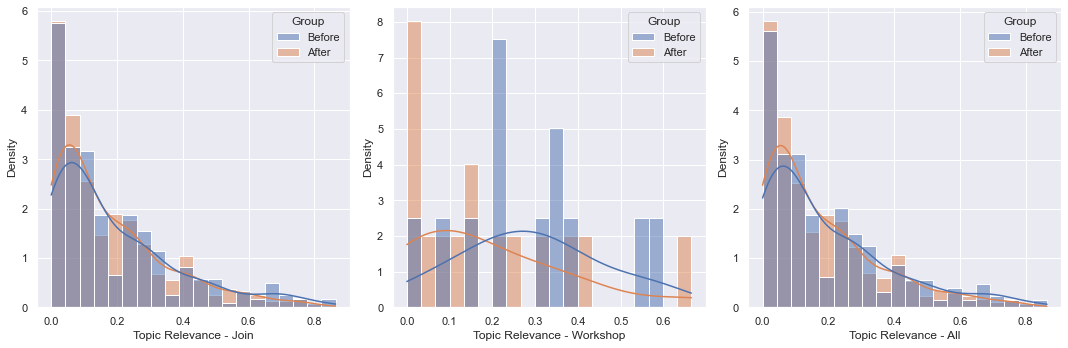

In [82]:
fig_df = df[index_filter(df, type='intra-subject')][relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

fig_df = fig_df.assign(Group=fig_df['group'])
fig_df['EventType'] = fig_df['event_type']
fig_df = fig_df.assign(Position=fig_df['position'].map(POSITIONS_MAP))

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist') & (fig_df['EventType'] == 'Joined')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[0])
axs[0].set_xlabel(xlabel='Topic Relevance - Join')

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist') & (fig_df['EventType'] == 'Workshop')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[1])
axs[1].set_xlabel(xlabel='Topic Relevance - Workshop')

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[2])
axs[2].set_xlabel(xlabel='Topic Relevance - All')

fig.tight_layout()
# plt.show()

plt.savefig('intra-subject-topic-relevance.png', bbox_inches='tight')

Participant        1278
Non-Participant     412
Name: Group, dtype: int64
279858.0 0.026931695692288208
0.09907169888146769 0.11633286494407968


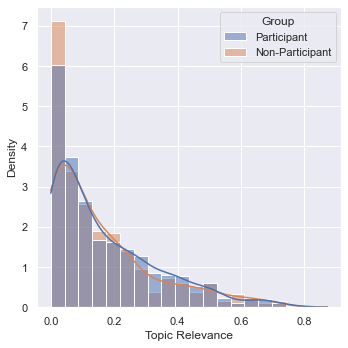

In [83]:
fig_df = df[index_filter(df, type='inter-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

fig_df = fig_df.assign(Group=fig_df['group'])
fig_df = fig_df.assign(Position=fig_df['position'].map(POSITIONS_MAP))

fig_df = fig_df[fig_df['event_type'] == 'None']
fig_df = fig_df[fig_df['Position'] == 'Meteorologist']

print(fig_df['Group'].value_counts())

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

sns.histplot(fig_df, x='Topic Relevance', hue='Group', bins=20, stat='density', kde=True, common_norm=False, ax=ax)
ax.set_xlabel(xlabel='Topic Relevance')

fig.tight_layout()
# plt.show()
plt.savefig('inter-subject-topic-relevance.png', bbox_inches='tight')

participant_s = fig_df[fig_df['Group'] == 'Participant']['Topic Relevance']
non_participant_s = fig_df[fig_df['Group'] == 'Non-Participant']['Topic Relevance']

U1, p = mannwhitneyu(participant_s, non_participant_s, alternative='greater')
print(U1, p)
print(non_participant_s.median(), participant_s.median())

In [ ]:
sorted(df.index.get_level_values('index').unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [50]:
data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

consistency_df = data_df.mean(axis=1) / data_df.std(axis=1)

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']

sub_fig_df = sub_fig_df.assign(Position=sub_fig_df['position'].map(POSITIONS_MAP))
sub_fig_df = sub_fig_df[sub_fig_df['Position'] == 'Meteorologist']

,type,group,subject_id,event_id,event_type,position,Consistency,Group,Position
1,intra-subject-consistency,After,2067040562,327590147888,Joined,Meteorologist,1.801923,After,Meteorologist
2,intra-subject-consistency,After,3720444843,33734584217,Joined,Meteorologist,1.675555,After,Meteorologist
3,intra-subject-consistency,After,3773619596,427766343218,Joined,Meteorologist,0.968658,After,Meteorologist
4,intra-subject-consistency,After,4283195733,100791237412,Joined,Meteorologist,0.609845,After,Meteorologist
5,intra-subject-consistency,After,5077960503,109960214346,Joined,Meteorologist,1.053634,After,Meteorologist
...,...,...,...,...,...,...,...,...,...
1015,intra-subject-consistency,Before,1081989942200,586487439776,Joined,Meteorologist,1.583837,Before,Meteorologist
1016,intra-subject-consistency,Before,1084511065922,940531415265,Joined,Meteorologist,0.756538,Before,Meteorologist
1019,intra-subject-consistency,Before,1087954195310,597662257133,Joined,Meteorologist,0.768937,Before,Meteorologist
1022,intra-subject-consistency,Before,1095230417138,986426346906,Joined,Meteorologist,1.130641,Before,Meteorologist


21818.0 0.4777809611677058
66596.0 0.7134916287187081


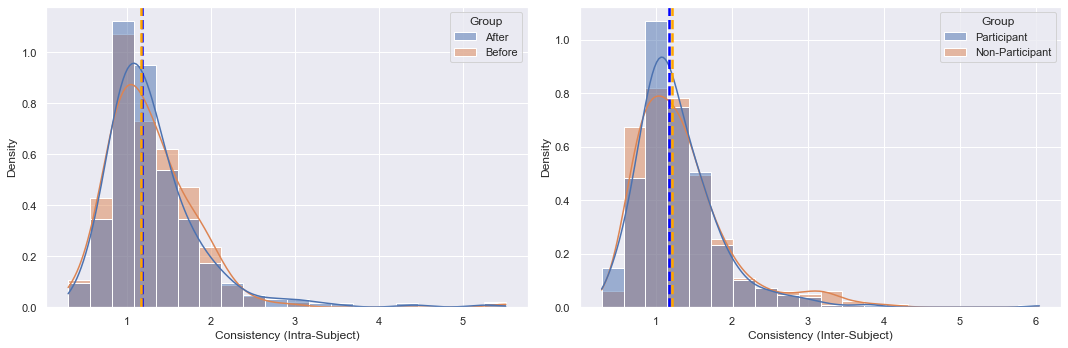

In [78]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

data_df = data_df[data_df.std(axis=1) != 0]

consistency_df = data_df.mean(axis=1) / data_df.std(axis=1)

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']

sub_fig_df = sub_fig_df.assign(Position=sub_fig_df['position'].map(POSITIONS_MAP))
sub_fig_df = sub_fig_df[sub_fig_df['Position'] == 'Meteorologist']

sns.histplot(sub_fig_df, x='Consistency', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[0],
                hue_order=['After', 'Before'])
axs[0].set_xlabel(xlabel='Consistency (Intra-Subject)')

after_s = sub_fig_df[sub_fig_df['Group']=='After']['Consistency']
axs[0].axvline(x=after_s.median(), 
               color='blue', ls='--', lw=2.5)

before_s = sub_fig_df[sub_fig_df['Group']=='Before']['Consistency']
axs[0].axvline(x=before_s.median(), 
               color='orange', ls='--', lw=2.5)

U1, p = mannwhitneyu(after_s, before_s, alternative='greater')
print(U1, p)

# 

data_df = df[index_filter(df, type='inter-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

data_df = data_df[data_df.std(axis=1) != 0]

consistency_df = data_df.mean(axis=1) / data_df.std(axis=1) 

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']

sub_fig_df = sub_fig_df.assign(Position=sub_fig_df['position'].map(POSITIONS_MAP))
sub_fig_df = sub_fig_df[sub_fig_df['Position'] == 'Meteorologist']

sns.histplot(sub_fig_df, x='Consistency', bins=20, hue='Group', stat='density', 
             kde=True, common_norm=False, ax=axs[1], hue_order=['Participant', 'Non-Participant'])
axs[1].set_xlabel(xlabel='Consistency (Inter-Subject)')

participant_s = sub_fig_df[sub_fig_df['Group']=='Participant']['Consistency']
axs[1].axvline(x=participant_s.median(), color='blue', ls='--', lw=2.5)

non_participant_s = sub_fig_df[sub_fig_df['Group']=='Non-Participant']['Consistency']
axs[1].axvline(x=non_participant_s.median(), color='orange', ls='--', lw=2.5)

U1, p = mannwhitneyu(participant_s, non_participant_s, alternative='greater')
print(U1, p)

axs[1].set_xlabel(xlabel='Consistency (Inter-Subject)')

fig.tight_layout()
plt.show()

In [412]:
data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

consistency_df = data_df.std(axis=1) / data_df.mean(axis=1)

data_df = consistency_df\
        .reset_index(drop=False, name='Consistency')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

data_df = data_df[data_df['Position']!='Other']

count_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['Consistency'], aggfunc='count', margins=2)[['Consistency']]
pivot_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['Consistency'], margins=2)[['Consistency']]

pivot_df.drop(labels=[('Consistency', 'All')], axis=1, inplace=True)

pivot_df['\\Delta'] = (pivot_df[('Consistency', 'Before')]-pivot_df[('Consistency', 'After')]) * 100 / pivot_df[('Consistency', 'Before')]

pivot_df = pivot_df.applymap("{0:.2f}".format)

pivot_df['Support'] = count_df.sum(axis=1)

print(pivot_df.to_latex())

\begin{tabular}{lllllr}
\toprule
    & {} & \multicolumn{2}{l}{Consistency} & \textbackslash Delta & Support \\
    & group &       After & \multicolumn{3}{l}{Before} \\
Event Type & Position &             &        &        &         \\
\midrule
Join & Meteorologist &        1.16 &   1.23 &   5.53 &    1318 \\
    & Reporter &        0.48 &   0.45 &  -6.75 &    1054 \\
Workshop & Meteorologist &        1.04 &   1.12 &   6.56 &      54 \\
    & Reporter &        0.60 &   0.69 &  13.33 &     582 \\
All &          &        0.82 &   0.83 &   1.33 &    3008 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_67041/2102006836.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivot_df.to_latex())
